#### Metrics Documentation (Classification and Regression)

#https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

In [2]:
import os 
import json
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_auc_score, mean_squared_error

In [3]:
import os
# Office
os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction')
data = pd.read_csv('LoanTrain.csv')

# Personal
#os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction')
#data = pd.read_csv('Loan Prediction Train.csv')

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

class PreProcessing(BaseEstimator, TransformerMixin):


    def __init__(self):
        pass

    def transform(self, df):

        pred_var = ['Gender','Married','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
        
        df = df[pred_var].reset_index(drop=True)
        
        #df['Dependents'] = df['Dependents'].fillna(0)
        df['Self_Employed'] = df['Self_Employed'].fillna('No')
        df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(self.term_mean_)
        df['Credit_History'] = df['Credit_History'].fillna(1)
        df['Married'] = df['Married'].fillna('No')
        df['Gender'] = df['Gender'].fillna('Male')
        df['LoanAmount'] = df['LoanAmount'].fillna(self.amt_mean_)
        
        #loading a MINMAX Scaler from a file called minmax_pickle.pkl
        MinMaxpickle_in = open("C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\minmax_pickle.pkl","rb")
        MinmaxScaler_dict = pickle.load(MinMaxpickle_in)
        df['ApplicantIncome']=pd.DataFrame(MinmaxScaler_dict['ApplicantIncome'].fit_transform(df[['ApplicantIncome']]))
        
        #loading a One Hot Encoder Scaler from a file called binarizer_pickle.pkl
        Onehotpickle_in = open("C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\binarizer_pickle.pkl","rb")
        Onehot_dict = pickle.load(Onehotpickle_in)
        d1=pd.DataFrame(Onehot_dict['Self_Employed'].fit_transform(df[['Self_Employed']]))
        d2=pd.DataFrame(Onehot_dict['Married'].fit_transform(df[['Married']]))
        d3=pd.DataFrame(Onehot_dict['Gender'].fit_transform(df[['Gender']]))
        d=pd.concat([d1,d2,d3],axis=1)
        col=['Self_Employed_0','Married_0','Gender_0']
        d.columns=col
        df.drop(['Self_Employed','Married','Gender'],axis=1,inplace=True)
        df=pd.concat([df,d],axis=1)
        
        ## Loading a Label encoder scaler from a file called labelencoder_pickle
        Labelencoderpickle_in = open("C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\labelencoder_pickle.pkl","rb")
        Labelencoder_dict = pickle.load(Labelencoderpickle_in)
        df['Education']=pd.DataFrame(Labelencoder_dict['Education'].fit_transform(df[['Education']]))
        df['Property_Area']=pd.DataFrame(Labelencoder_dict['Property_Area'].fit_transform(df[['Property_Area']]))
        df['Credit_History']=pd.DataFrame(Labelencoder_dict['Credit_History'].fit_transform(df[['Credit_History']]))
        #df['Dependents']=pd.DataFrame(Labelencoder_dict['Dependents'].fit_transform(df[['Dependents']]))
        #df['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(df[['Loan_Status']]))
        return df.as_matrix()

    def fit(self, df, y=None, **fit_params):
        self.term_mean_ = df['Loan_Amount_Term'].mean()
        self.amt_mean_ = df['LoanAmount'].mean()
        return self

In [5]:
pred_var = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
X_train, X_test, y_train, y_test = train_test_split(data[pred_var], data['Loan_Status'], test_size=0.25, random_state=42)

In [6]:
preprocess = PreProcessing()

In [7]:
preprocess.fit(X_train)

PreProcessing()

In [8]:
data_transformed_xtrain = preprocess.transform(X_train)

In [9]:
pred_var = ['Education','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Self_Employed_0','Married_0','Gender_0']
data_transformed_xtrain=pd.DataFrame(data_transformed_xtrain,columns=pred_var)
data_transformed_xtrain.head()
#data_transformed['Dependents'].unique()

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_0,Married_0,Gender_0
0,1.0,0.038627,1820.0,81.0,360.0,1.0,2.0,0.0,1.0,1.0
1,0.0,0.047619,2500.0,140.0,360.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.085962,0.0,125.0,60.0,1.0,2.0,1.0,1.0,1.0
3,0.0,0.059369,0.0,125.0,360.0,1.0,2.0,0.0,0.0,1.0
4,0.0,0.040569,1250.0,128.0,360.0,0.0,1.0,0.0,1.0,1.0


In [10]:
data_transformed_xtest = preprocess.transform(X_test)

In [11]:
pred_var = ['Education','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Self_Employed_0','Married_0','Gender_0']
data_transformed_xtest=pd.DataFrame(data_transformed_xtest,columns=pred_var)
data_transformed_xtest.head()

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_0,Married_0,Gender_0
0,0.0,0.140558,0.0,228.0,360.0,1.0,1.0,0.0,1.0,1.0
1,0.0,0.064948,0.0,130.0,360.0,1.0,1.0,0.0,1.0,1.0
2,0.0,0.062683,1447.0,158.0,360.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.042613,0.0,71.0,360.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.039729,0.0,70.0,360.0,1.0,1.0,0.0,0.0,1.0


In [12]:
y_train=pd.DataFrame(y_train).reset_index(drop=True)
y_train.columns=['Loan_Status']

y_test=pd.DataFrame(y_test).reset_index(drop=True)
y_test.columns=['Loan_Status']

Labelencoderpickle_in = open("C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\labelencoder_pickle.pkl","rb")
Labelencoder_dict = pickle.load(Labelencoderpickle_in)

y_train['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(y_train[['Loan_Status']]))
y_test['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(y_test[['Loan_Status']]))


In [13]:
import warnings; warnings.simplefilter('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split, GridSearchCV

parameters1={'max_depth':[2,3,4,6,8,10],'max_features':[2,4,6,8],'min_samples_leaf':[0.1,0.2,0.3],'min_samples_split':[0.1,0.2,0.3]}
dtc=DecisionTreeClassifier()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    DTC_gridsearchcv=GridSearchCV(dtc,parameters1,cv=3,scoring='%s_macro' % score)
    DTC_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',DTC_gridsearchcv.best_params_)
    print('CV Results Keys: \n',DTC_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',DTC_gridsearchcv.cv_results_)
    #print('CV Results values: \n',DTC_gridsearchcv.cv_results_.values())

Best Parameters: {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


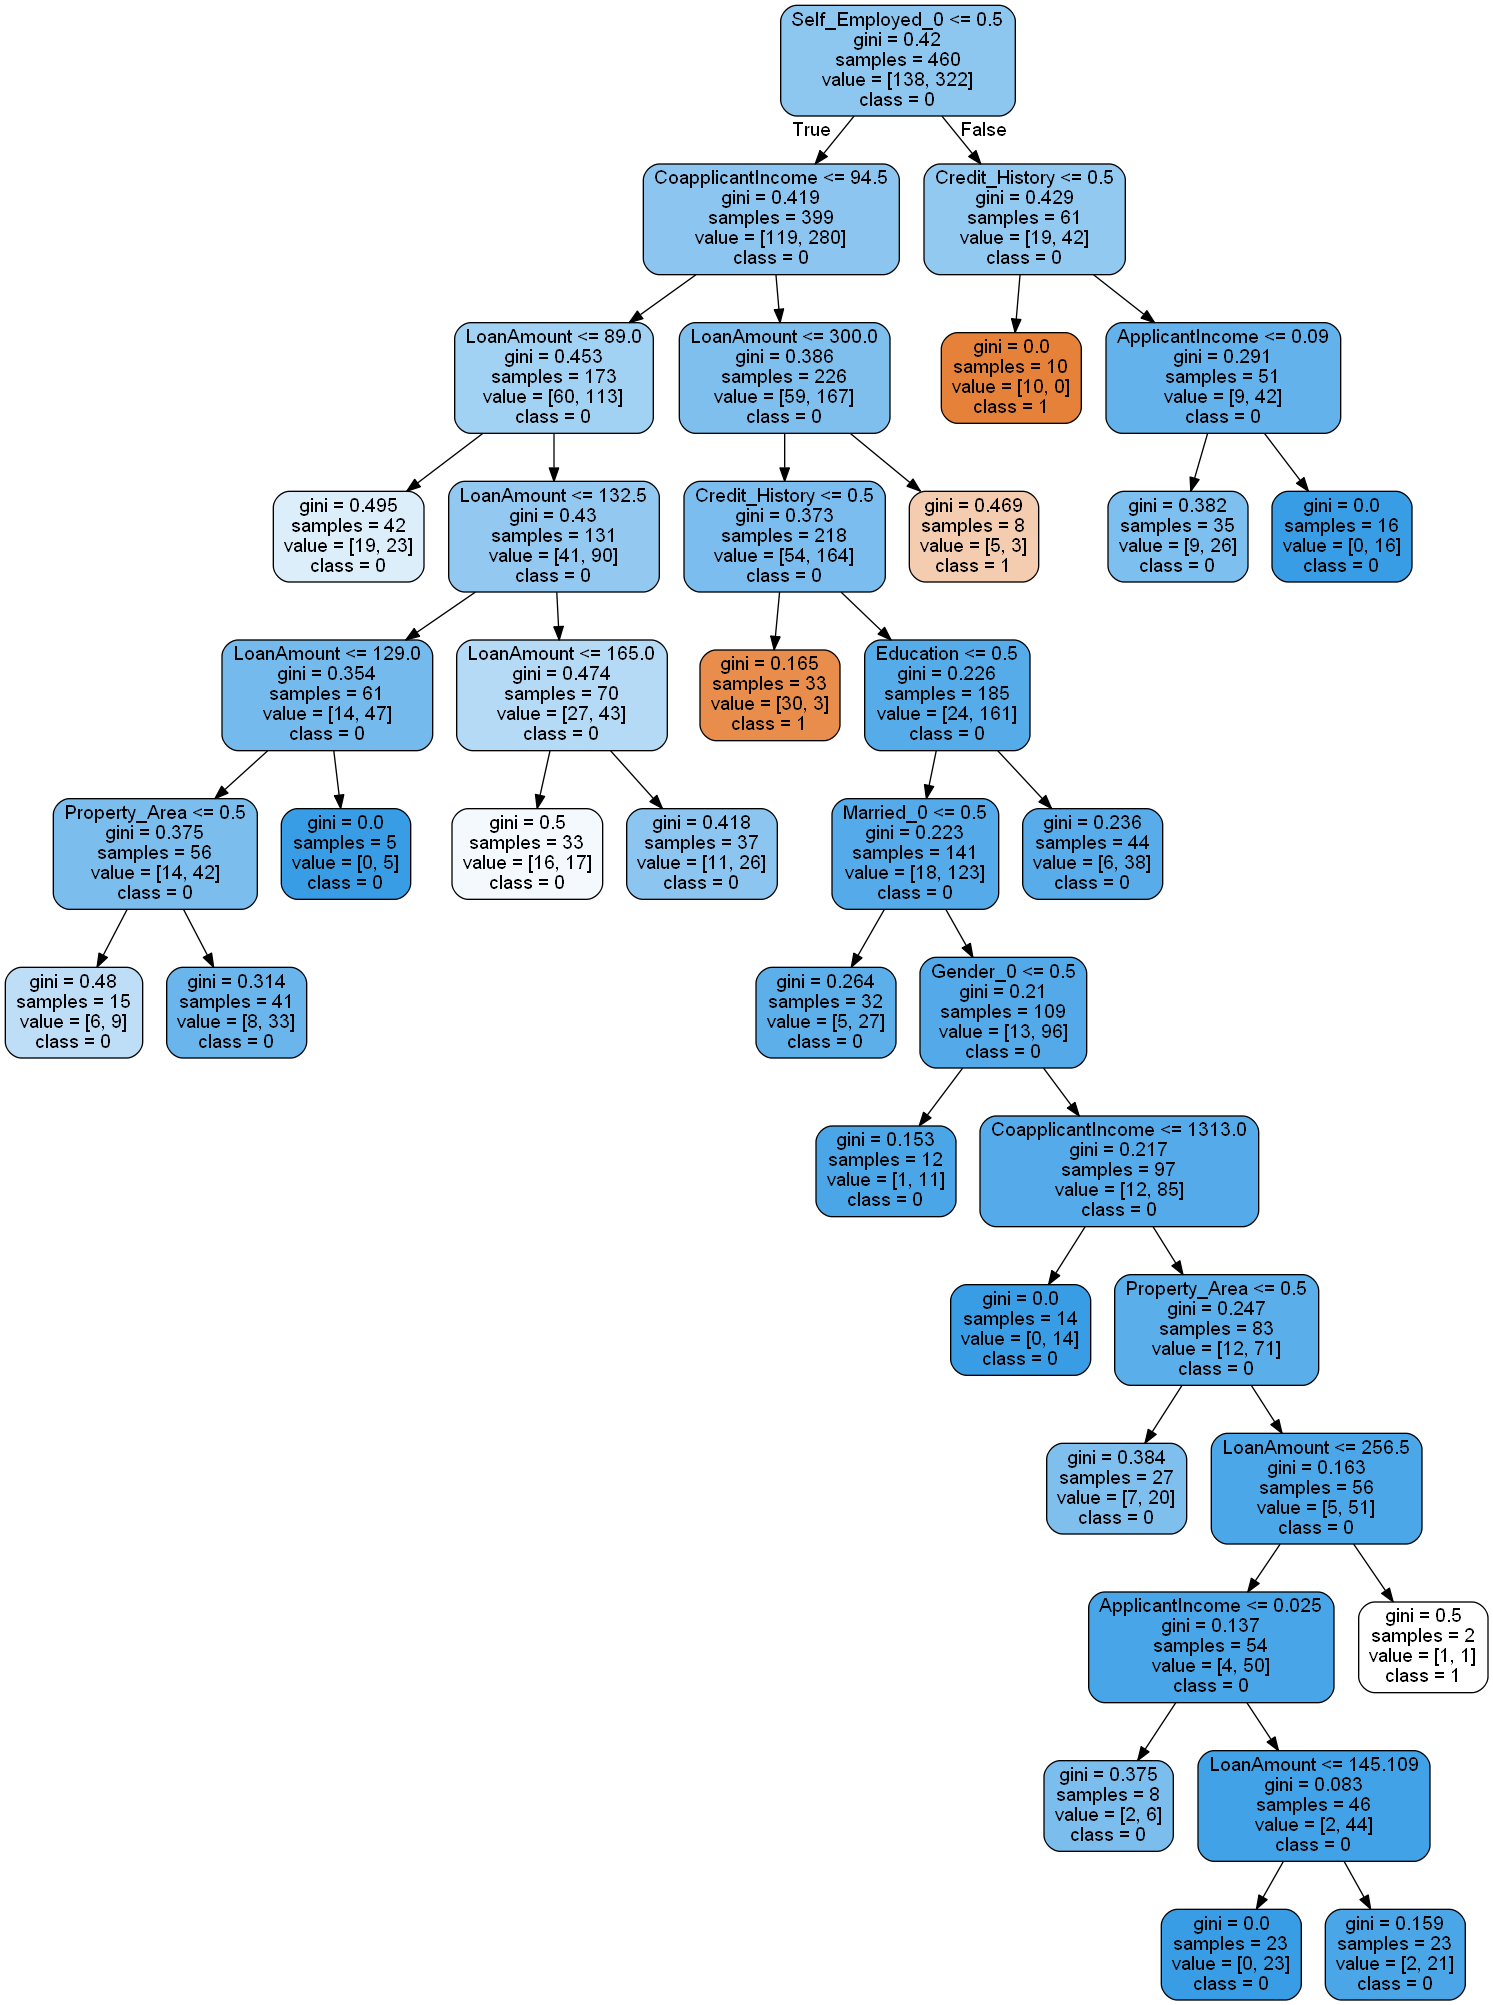

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image, display

DT=DecisionTreeClassifier(max_features=1, min_samples_split=0.1)
DT.fit(data_transformed_xtrain,y_train)
classes=list(DT.classes_)
print(DT)

## Plotting the Decision Tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = tree.export_graphviz(DT, out_file=None,
                                    feature_names=data_transformed_xtrain.columns,
                                    class_names=['1','0'],
                                    filled=True, rounded=True)
 
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(data=graph.create_png()))

In [17]:
print('Classes: ',DT.classes_)
print('Feature Importance: ',pd.DataFrame(DT.feature_importances_,index=data_transformed_xtrain.columns))

Classes:  [0 1]
Feature Importance:                            0
Education          0.000000
ApplicantIncome    0.000000
CoapplicantIncome  0.038156
LoanAmount         0.000000
Loan_Amount_Term   0.000000
Credit_History     0.920974
Property_Area      0.040869
Self_Employed_0    0.000000
Married_0          0.000000
Gender_0           0.000000


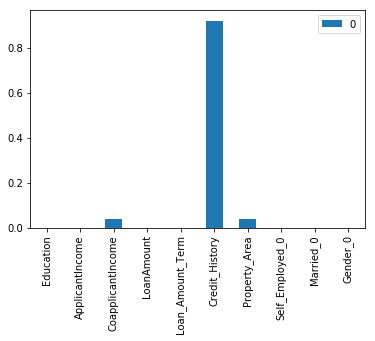

In [18]:
Feature_Importance=pd.DataFrame(DT.feature_importances_,index=data_transformed_xtrain.columns)
Feature_Importance.plot(kind='bar')

In [19]:
print(DT.max_depth)

None


### Lime

In [22]:
from sklearn.tree import DecisionTreeClassifier
nb=DecisionTreeClassifier()
nb.fit(data_transformed_xtrain,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(nb)

In [20]:
class_names=np.unique(y_train)

In [21]:
from lime.lime_text import LimeTextExplainer
import lime
import lime.lime_tabular
explainer = LimeTextExplainer(class_names=class_names)

In [33]:
idx = 3
exp = explainer.explain_instance(list(data_transformed_xtrain.loc[idx,:]), c.predict_proba, num_features=6, labels=[0])
print('Document id: %d' % idx)
print('Predicted class =', class_names[nb.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

TypeError: expected string or bytes-like object

In [32]:
list(data_transformed_xtrain.loc[3,:])

[0.0, 0.05936920222634509, 0.0, 125.0, 360.0, 1.0, 2.0, 0.0, 0.0, 1.0]